### Build a Sequential Neural Network using the familiar Census Data

In [1]:
# From last week

import tensorflow as tf
import keras
import numpy as np
import pandas as pd

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
# tf.config.experimental.set_memory_growth(gpus[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1. Import the now (very) familiar US Census Income Data

In [3]:
import pandas
from sklearn.svm import SVC
import sklearn
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

col_names = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

df = pandas.read_csv('census_data.csv')
df.columns=col_names
# df['Income'] = df['Income'].apply(lambda x: 0 if x == ' <=50K' else 1)

for column in df.columns:
    if df[column].dtype == type(object):
        le = sklearn.preprocessing.LabelEncoder()
        df[column] = le.fit_transform(df[column])
df.tail()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
48837,27,4,257302,7,12,2,13,5,4,0,0,0,38,39,0
48838,40,4,154374,11,9,2,7,0,4,1,0,0,40,39,1
48839,58,4,151910,11,9,6,1,4,4,0,0,0,40,39,0
48840,22,4,201490,11,9,4,1,3,4,1,0,0,20,39,0
48841,52,5,287927,11,9,2,4,5,4,0,15024,0,40,39,1


### 2. Split the data and use preprocessing StandardScaler on the data

In [4]:
X = df.drop(columns='Income')
X = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(X), columns=X.columns)
y = df['Income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=555, stratify=y)

### 3. Use the Tensorflow and Keras libraries from last week to build a NN.

*Use today's class notes as a guild.  Try using different activation functions

In [5]:
nn_X_train = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
nn_X_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# mdl_k = tf.keras.Sequential([tf.keras.layers.Input(shape=(nn_X_train.shape[1], nn_X_train.shape[2]))])

In [6]:
# create model
mdl_k = tf.keras.Sequential([tf.keras.layers.Input(shape=(nn_X_train.shape[1], nn_X_train.shape[2]))])
mdl_k.add(tf.keras.layers.Dense(12, input_dim=3, activation='softmax', kernel_initializer="he_normal"))
# mdl_k.add(tf.keras.layers.Dense(8, activation='relu'))

mdl_k.add(tf.keras.layers.LSTM(64))
#mdl_k.add(tf.keras.layers.LeakyReLU(alpha=0.2))
mdl_k.add(tf.keras.layers.Dense(1, activation='elu'))

In [7]:
# Compile model
mdl_k.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

In [8]:
mdl_k.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14, 12)            24        
_________________________________________________________________
lstm (LSTM)                  (None, 64)                19712     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 19,801
Trainable params: 19,801
Non-trainable params: 0
_________________________________________________________________


In [9]:
val_dataset = tf.data.Dataset.from_tensor_slices((nn_X_test, y_test)).batch(batch_size=128)

In [10]:
history = mdl_k.fit(
    nn_X_train,
    y_train,
    epochs=50,
    batch_size=128,
    # validation_data=(nn_X_test, y_test),
    validation_data=val_dataset,
    #validation_split=0.1,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=2)
#     ],
    use_multiprocessing=True
)

Epoch 1/50
306/306 [==============================] - 5s 17ms/step - loss: 0.1539 - accuracy: 0.7796 - val_loss: 0.1471 - val_accuracy: 0.7881
Epoch 2/50
306/306 [==============================] - 4s 13ms/step - loss: 0.1378 - accuracy: 0.8004 - val_loss: 0.1325 - val_accuracy: 0.8082
Epoch 3/50
306/306 [==============================] - 4s 13ms/step - loss: 0.1307 - accuracy: 0.8104 - val_loss: 0.1309 - val_accuracy: 0.8064
Epoch 4/50
306/306 [==============================] - 4s 13ms/step - loss: 0.1239 - accuracy: 0.8219 - val_loss: 0.1239 - val_accuracy: 0.8174
Epoch 5/50
306/306 [==============================] - 4s 13ms/step - loss: 0.1217 - accuracy: 0.8235 - val_loss: 0.1193 - val_accuracy: 0.8252
Epoch 6/50
306/306 [==============================] - 4s 13ms/step - loss: 0.1198 - accuracy: 0.8278 - val_loss: 0.1168 - val_accuracy: 0.8287
Epoch 7/50
306/306 [==============================] - 4s 12ms/step - loss: 0.1184 - accuracy: 0.8305 - val_loss: 0.1212 - val_accuracy: 0.8236

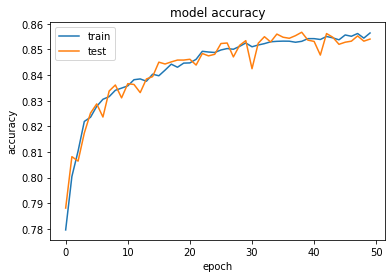

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Got the Perfect Model without overfitting

### 4. Build an xgBoost model on this data.  Were you able to build a NN with greater accuracy than xgBoost ?

In [12]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold

In [13]:

xg_params = {
    'eta': [0.01, 0.025, 0.05, 0.075, 0.25, 0.3, 0.5],
    'max_depth': [3, 5, 6, 7, 9],
    'tree_method': ['gpu_hist'],
    'predictor': ['gpu_predictor']
}

In [14]:
clf_XGB = XGBClassifier(n_estimators = 100, objective= 'binary:logistic', seed=555)
grid2 = GridSearchCV(clf_XGB, xg_params, scoring="roc_auc", cv=5, verbose=10, n_jobs=-1)
grid2.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:  5

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=555,
                                     subsample=None, tree_metho

In [ ]:
results = sklearn.model_selection.cross_val_score(grid2.best_estimator_, X_train,y_train, cv=5)
print ("Accuracy - Train CV: ", results.mean())

tr = grid2.best_estimator_.predict(X_train), y_train.tolist()
te = grid2.best_estimator_.predict(X_test), y_test.tolist()
# print(te)

print ("Accuracy - Train : ", sklearn.metrics.accuracy_score(grid2.best_estimator_.predict(X_train), y_train))
print ("Accuracy - Test : ", sklearn.metrics.accuracy_score(grid2.best_estimator_.predict(X_test), y_test))

In [ ]:
# We can see from above that XGboost gives more aaccuracy than our Neural Network